## The value the model seeks to predict is the `mvp_share` column, which represents the result of the MVP voting for each season.

### mvp_share $= \frac{PtsWon}{PtsMax}$

In [23]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import shap
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

import joblib

# Load the saved best model from modeling.ipynb
xgb = joblib.load('best_xgb_model.pkl')

In [24]:
# Load the dataa
df_selected = pd.read_csv('df_selected.csv')
features = list(df_selected.columns)
features.append('mvp_share')
features.append('Rank')
df_train = pd.read_csv('df_clean.csv', usecols=features)
label_col_name = "mvp_share"
labels = df_train.pop(label_col_name)
stratify = df_train.pop("Rank")
del features[10]
del features[10]
df_last = pd.read_csv('df_last.csv', usecols=features)
last_seasons = pd.read_csv('last_seasons.csv')
last_names = pd.read_csv('last_names.csv')

df_test = pd.concat([df_last, last_seasons, last_names], axis=1).reset_index(drop=True)
df_test.rename(columns={'name': 'Name'}, inplace=True)

In [25]:
(X_train, X_test, y_train, y_test) = train_test_split(df_train, 
                                                      labels, 
                                                      test_size=0.2, 
                                                      shuffle=True, 
                                                      random_state=28, 
                                                      stratify=stratify)

# Convert each dataset to array
y_train = y_train.values
y_test = y_test.values
X_train = X_train.values
X_test = X_test.values

#### Use the best model from `Models.ipynb`

In [26]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.07954844829039878, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1560738525819043,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=201, n_jobs=None,
             num_parallel_tree=None, random_state=28, ...)

### Testing

In [27]:
# Make predictions on the test data using the best model
y_pred = xgb.predict(X_test)

# Evaluate the best model using mean squared error and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test MSE:", mse)
print("Test R-squared:", r2)

Test MSE: 0.001361859185915247
Test R-squared: 0.7331359376714274


---

In [28]:
dfs_n_last = []
for season_n in df_test['Season'].unique():
        df_n = df_test[df_test['Season'] == season_n].copy()
        names_n = df_n["Name"].values
        df_n.drop(['Season', 'Name'], axis="columns", inplace=True)
        feature_n = df_n.to_numpy()

        prediction = xgb.predict(feature_n)
        df_curr_season_victory = pd.DataFrame(data=feature_n, index=None, columns=features)
        df_curr_season_victory['Season'] = season_n
        df_curr_season_victory['Player'] = names_n
        df_curr_season_victory['MVP_Shares_in_%'] = prediction * 100
        dfs_n_last.append(df_curr_season_victory)
        df_curr_season_victory = df_curr_season_victory.sort_values(by=['MVP_Shares_in_%'], ascending=False, ignore_index=True)
        
        print(season_n)
        print(df_curr_season_victory[['Player', 'MVP_Shares_in_%']].head(8))
        print("=============================================================================")
        print("============================================================================\n")
        
dfs_n_last = pd.concat(dfs_n_last, ignore_index=True)
dfs_n_last.to_csv("predictions.csv", index=False, encoding="utf-8-sig")

2022
                  Player  MVP_Shares_in_%
0           Nikola Jokić        54.515709
1  Giannis Antetokounmpo        35.700180
2            Joel Embiid        17.814123
3              Ja Morant        16.468599
4            Luka Dončić        16.206421
5           Jimmy Butler         7.865128
6           Jayson Tatum         6.817160
7        Robert Williams         5.785182

2021
                  Player  MVP_Shares_in_%
0           Nikola Jokić        56.660305
1  Giannis Antetokounmpo        17.404875
2            Joel Embiid        14.760483
3           Kyrie Irving        14.431928
4            Luka Dončić        14.086821
5            Rudy Gobert        10.469152
6          Stephen Curry         9.140865
7         Damian Lillard         8.765725

2020
                  Player  MVP_Shares_in_%
0  Giannis Antetokounmpo        33.643948
1           James Harden        32.710815
2          Anthony Davis        28.110933
3           LeBron James        26.905361
4          Kawhi 

---

# Compare Against True Share

In [29]:
df_pred = pd.read_csv('predictions.csv')
df_pred.rename(columns={'Player': 'name'}, inplace=True)
keep = list(df_pred.columns)
del keep[12]
keep.append('mvp_share')

df_full = pd.read_csv('mvp_data_edit.csv', usecols=keep)

# Merge df_pred with df_full on "name" and "Season" columns
merged_df = pd.merge(df_pred, df_full[['name', 'Season', 'mvp_share']], 
                     on=['name', 'Season'], how='left')

# Rename the 'mvp_share' column to 'actual' in the merged dataframe
merged_df.rename(columns={'mvp_share': 'actual', 'MVP_Shares_in_%': 'predicted'}, inplace=True)

merged_df['actual'] *= 100

In [30]:
# Define a function to format the tick labels without decimal places
def percent_formatter(x, pos):
    return f"{int(x)}%"

# Define custom colors for 'predicted' and 'actual'
custom_palette = {'predicted': '#E57200', 'actual': '#232D4B'}

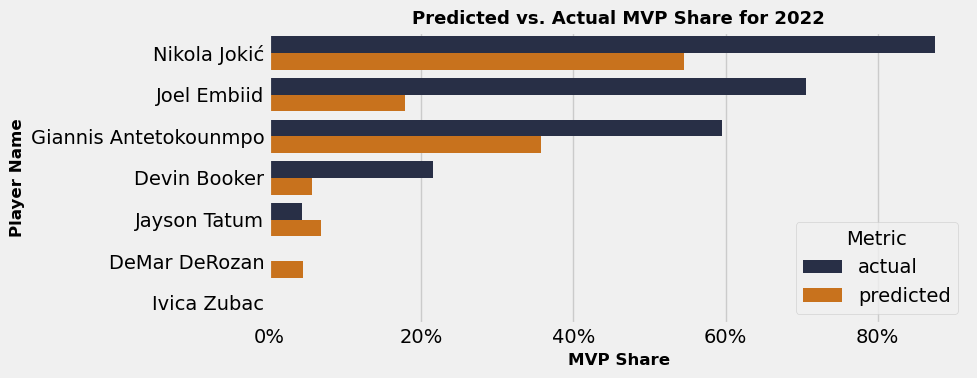

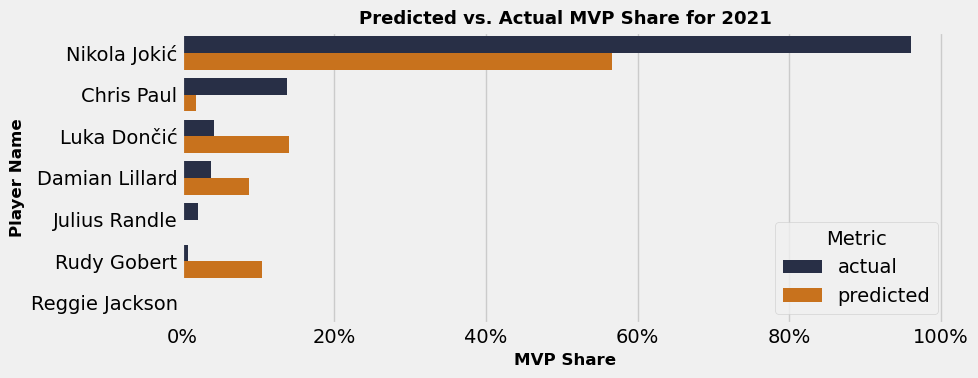

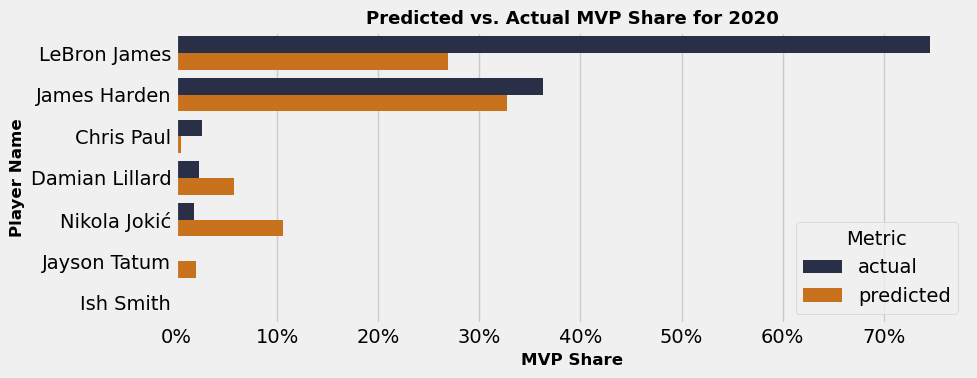

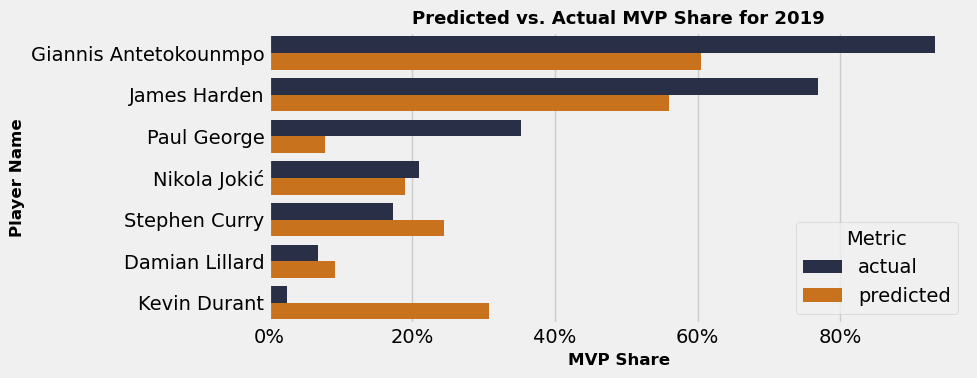

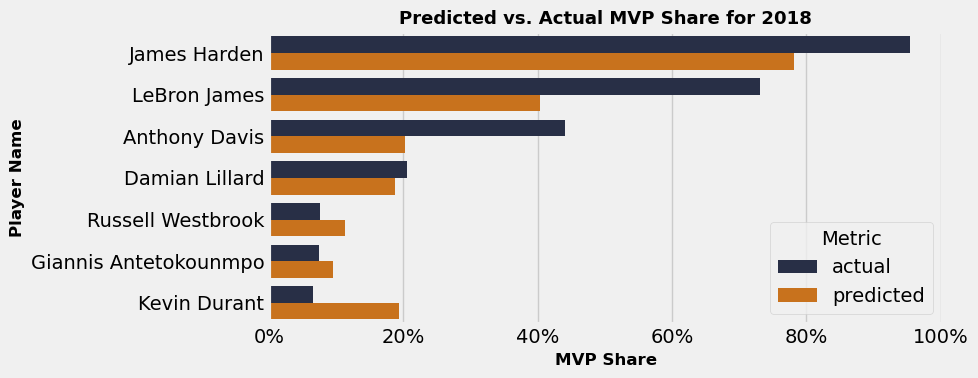

In [31]:
# Iterate over unique values in the 'Season' column and create separate plots for each
unique_seasons = merged_df['Season'].unique()

for season in unique_seasons:
    # Filter data for the current season
    season_data = merged_df[merged_df['Season'] == season]
    
    # Filter the data to include only the top 7 values of 'actual' for the current season
    top_7_actual = season_data.nlargest(7, 'actual')
    
    # Group the filtered data by 'name' and calculate mean of 'actual' and 'predicted' columns
    grouped_df = top_7_actual.groupby('name')[['actual', 'predicted']].mean().reset_index()
    
    # Sort the grouped dataframe by 'actual' values
    grouped_df.sort_values(by='actual', ascending=False, inplace=True)

    # Melt the grouped dataframe to long format for easy plotting
    melted_df = grouped_df.melt(id_vars='name', var_name='Metric', value_name='Value')

    # Plot the grouped horizontal bar chart
    plt.figure(figsize=(10, 4))
    plt.style.use('fivethirtyeight')
    ax = sns.barplot(data=melted_df, x='Value', y='name', 
                     hue='Metric', palette=custom_palette, orient='h')
    plt.xlabel('MVP Share', weight='bold', size=12)
    plt.ylabel('Player Name', weight='bold', size=12)
    plt.title(f'Predicted vs. Actual MVP Share for {season}', weight='bold', size=13)
    plt.legend(title='Metric', loc='lower right')
    ax.xaxis.set_major_formatter(FuncFormatter(percent_formatter))
    plt.tight_layout()
    plt.show()